### Purpose: 

1. To create images containing text, generated using handwriting-like fonts downloaded from the [Google Fonts GitHub Repo](https://github.com/google/fonts/tree/master/ofl).
  - The function *image_from_font* generates the image given a .ttf font file.
  - Data augmentation is then applied to generate some random variations of each image.
  - These images can be used to train any OCR model that might want to be used for transcription of users' writing submission images, or to test existing tools.
2. To test the pytesseract library "out of the box" on these generated images, as well as on some real-life handwriting samples.
  - Pre-processing is applied, and pytesseract is used to transcribe processed images.
3. To set up the use of a pre-fit neural network model which has been trained on the EMNIST dataset, to make predictions (transcriptions) from new text images.
  - A simple neural network model is fit on the EMNIST dataset.
  - In order to use this or any other model which is trained on individual images of letters, to transcribe a new text image, the image will need to be broken up into all of its individual characters by use of bounding boxes. These individual letter images will then be fed to the model to make predictions for transcription.

## **Note:** 
#### *This notebook was created and is intended to be run in Google Colab.*

In [1]:
 %%capture
!pip install pytesseract
!sudo apt install tesseract-ocr

In [2]:
# Find out where the pytesseract execution file resides
!which tesseract

/usr/bin/tesseract


In [2]:
from PIL import Image, ImageDraw, ImageFont
import os
import pytesseract
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
import numpy as np

In [3]:
# ---> specify the location of the pytesseract .exe file, from your call to "which tesseract" above <---
pytesseract.pytesseract.tesseract_cmd = (
    r'/usr/bin/tesseract'
)

In [4]:
# First get some fonts from the Google Fonts Github Repo
# https://github.com/google/fonts/tree/master/ofl
%%capture
!wget https://github.com/google/fonts/blob/master/ofl/indieflower/IndieFlower-Regular.ttf?raw=true -O IndieFlower-Regular.ttf
!wget https://github.com/google/fonts/blob/master/ofl/chilanka/Chilanka-Regular.ttf?raw=true -O Chilanka-Regular.ttf
!wget https://github.com/google/fonts/blob/master/ofl/gaegu/Gaegu-Regular.ttf?raw=true -O Gaegu-Regular.ttf
!wget https://github.com/google/fonts/blob/master/ofl/justmeagaindownhere/JustMeAgainDownHere.ttf?raw=true -O JustMeAgainDownHere.ttf
!wget https://github.com/google/fonts/blob/master/ofl/waitingforthesunrise/WaitingfortheSunrise.ttf?raw=true -O WaitingfortheSunrise.ttf

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# The list of font files to use for generating text images
fonts = ['IndieFlower-Regular.ttf', 'Chilanka-Regular.ttf',
              'Gaegu-Regular.ttf','JustMeAgainDownHere.ttf','WaitingfortheSunrise.ttf']

In [7]:
# This is the path where the created images will be saved
# ---> Change this to your desired path <---

IMG_OUT_PATH = '/content/drive/MyDrive/Lambda/Labs/Img_Outs'


In [8]:
def image_from_font(msg, fontfiles=fonts, outfile_type='.jpg', img_size=(600,300), 
                    bg_color='lightgrey', font_size=14, pos=(50,50), text_color='rgb(0,0,0)',
                    aug_iters=10, img_out_path = IMG_OUT_PATH):
      """
      Produces a set of image files with a given message, in each of a 
      list of speficied fonts, and with some image augmentation methods -
      rotation, zoom, and brightness variations.
      Each image is output to a file named with the start of the message, 
      the font name, and the augmentation iteration number.
      The final image produced is also displayed as a sample.
      These images can be used to generate data for testing and/or training 
      of any OCR model.

      Data augmentation method from Jason Brownlee:
      https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/

      Inputs: font = a list of font files in .ttf format
            msg = the message to be drawn on the image
            outfile_type = the extension to add to the image file, 
            which will determine the file type: .jpg, .png, .gif, .bmp, or .tiff
            img_size = a tuple specifying the size of the image
            bg_color = background color of the image
            font_size = size of the font
            pos = a tuple specifying the starting position of the message, 
                  where (0,0) is the top left corner of the image
            text_color = color of the font text
            aug_iters = number of augmented variations of the image to produce
                        per font.
      
      """
      for style in fontfiles:
        # Draw a simple image with one color, as our background
        img = Image.new('RGB', (700, 1000), color = 'lightgrey')

        # initialize the drawing context with
        # the image object as background
        draw = ImageDraw.Draw(img)

        # create font object with the font file and specify
        # desired size 
        font_obj = ImageFont.truetype(style, size=font_size)
        
        # draw the message on the background
        draw.text(pos, msg, fill=text_color, font=font_obj)

        # format file names as a string, 
        # incorporating font name and msg
        img.save(IMG_OUT_PATH + "/" + msg[0:10].replace(" ", "_") + "_" 
                 + style.strip('.ttf') + "_raw" + outfile_type)
          
        # convert to numpy array
        data = img_to_array(img)
        # expand dimension to one sample
        samples = expand_dims(data, 0)
        # create image data augmentation generator
        # ---> these ranges may require some adjustment for different messages
        # ---> to prevent cutting off some of the text
        datagen = ImageDataGenerator(rotation_range = 15, 
                                     zoom_range=[0.8,1.0],
                                     brightness_range = [0.8,1.2])
        # prepare iterator
        it = datagen.flow(samples, batch_size=1)
        # generate samples and plot
        for i in range(aug_iters):
          # generate batch of images
          batch = it.next()
          # convert to unsigned integers for viewing
          image = batch[0].astype('uint8')
          # change augmented numpy array image back to image
          img_aug = Image.fromarray(image)
          # save augmented image to file
          img_aug.save(IMG_OUT_PATH + "/" + msg[0:10].replace(" ", "_") + "_" + style.strip('.ttf') + "_aug" + str(i) + outfile_type)

        pyplot.imshow(img)
         
      # show the final figure, as an example
      pyplot.show()

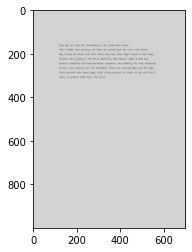

In [144]:
# Here's an example set of images being produced from the first paragraph
# of "Call of the Wild". 
# Different fonts and text blocks may require experimentation with the font size
# and starting position, in order for rotations and zooms to not cut off
# parts of the text.

image_from_font("""Buck did not read the newspapers, or he would have known 
that trouble was brewing, not alone for himself, but for every tide-water 
dog, strong of muscle and with warm, long hair, from Puget Sound to San Diego. 
Because men, groping in the Arctic darkness, had found a yellow metal, and 
because steamship and transportation companies were booming the find, thousands 
of men were rushing into the Northland. These men wanted dogs, and the dogs 
they wanted were heavy dogs, with strong muscles by which to toil, and furry 
coats to protect them from the frost.""", 
fontfiles=fonts, font_size=14, pos=(120,150))

### Next we'll try passing these back through Tesseract as is, and then with some image processing.


In [9]:
# This is a helper function for transcribe_images below.
# It changes the extension of a file name to .txt
def img_text_filename(img_file: str) -> str:
  """
  Replace image extension with ".txt"
  """
  split_name = img_file.split(".", 1)
  return split_name[0] + ".txt"

In [10]:
# This is the path where the transcribed text from images will be saved
# ---> Change this to your desired path <---

TXT_OUT_PATH = '/content/drive/MyDrive/Lambda/Labs/Txt_Outs'

In [12]:
# To send these images through tesseract and get the text back:

def transcribe_images(img_dir=IMG_OUT_PATH,
                      txt_dir=TXT_OUT_PATH) -> str:
  """
  Takes the file directory containing images of text, 
  Tesseract reads them,
  For each image, 
  writes a file to the txt_dir with transcription of the image.
  """
  # get a list of the image file names in the folder
  img_files = os.listdir(img_dir)

  # make the path to the directory for img files
  path_to_img = lambda file: img_dir + "/" + file

  # make a list of strings output by tesseract
  tess_text = [
               (pytesseract.image_to_string(path_to_img(p)), img_text_filename(p)) for p in img_files
               ]

  # make the path to the directory for output txt files
  path_to_txt = lambda file: txt_dir + "/" + file

  for text, txt_fname in tess_text:
    f = open(path_to_txt(txt_fname), 'w')
    f.write(text)
    f.close()
    

In [168]:
transcribe_images()

### ... A quick look at the files output shows that the results are pretty bad, taking in augmented/ degraded data, without any preprocessing of the images before giving them to Tesseract.
### So let's apply some preprocessing.

In [69]:
# Load image, apply grayscale and thresholding
image = cv2.imread('/content/drive/MyDrive/Lambda/Labs/Img_Outs/Buck_did_n_Chilanka-Regular_raw.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
thresh = 255 - cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

# Blur and perform text extraction
blur = cv2.GaussianBlur(thresh, (3,3), 0)
data = pytesseract.image_to_string(blur, lang='eng', config='--psm 6')
print(data)

Buck did not read the newspapers, or he would have known

thot trouble was brewing, not done for himself, but for every tide-water

dog, strong of muscle and with warm, long hair, from Puget Sound to San Diego.
Because men, groping in the Arctic darkness, had found ayelow meta, and

because steamship and transportation companies were booming the find, thousands
of men were rushing into the Northland. These men wanted dogs, and the dogs
they wanted were heavy dogs, with strong muscles by which to toll, and furry

coats to protect them trom the trost



Much better, just a few mistakes remain.

To make it more flexible, here are some functions that can be applied for various preprocessing. Mix and match for the particular purpose, though the ones most relevant to our situation will probably be thresholding, grayscale, and deskewing.



In [70]:
# get grayscale image
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# noise removal
def remove_noise(image):
    return cv2.GaussianBlur(image,(3,3),0)
 
#thresholding
def thresholding(image):
    return 255 - cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

#dilation
def dilate(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.dilate(image, kernel, iterations = 1)
    
#erosion
def erode(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.erode(image, kernel, iterations = 1)

#opening - erosion followed by dilation
def opening(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

#canny edge detection
def canny(image):
    return cv2.Canny(image, 100, 200)

#skew correction
def deskew(image):
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

#template matching
def match_template(image, template):
    return cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED)

## Try it out on any of the images we have.

### When we use images produced from any of the imported handwriting-like fonts, the preprocessing helps quite a bit, even though the de-skewing doesn't seem to work. The order of accuracy of Tessaract's transcriptions base on font are:
1. Chilanka
2. Indie Flower
3. Gaegu
4. Waiting for the Sunrise
5. Just Me Again Down Here

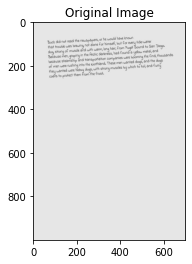

In [96]:
image = cv2.imread('/content/drive/MyDrive/Lambda/Labs/Img_Outs/Buck_did_n_IndieFlower-Regular_aug4.jpg')
b,g,r = cv2.split(image)
rgb_img = cv2.merge([r,g,b])
plt.imshow(rgb_img)
plt.title('Original Image')
plt.show()

In [97]:
gray = get_grayscale(image)
thresh = thresholding(gray)
derotate = deskew(gray)
denoise = remove_noise(gray)
images = {'gray': gray, 
          'thresh': thresh, 
          'deskew': derotate, 
          'remove_noise': denoise}

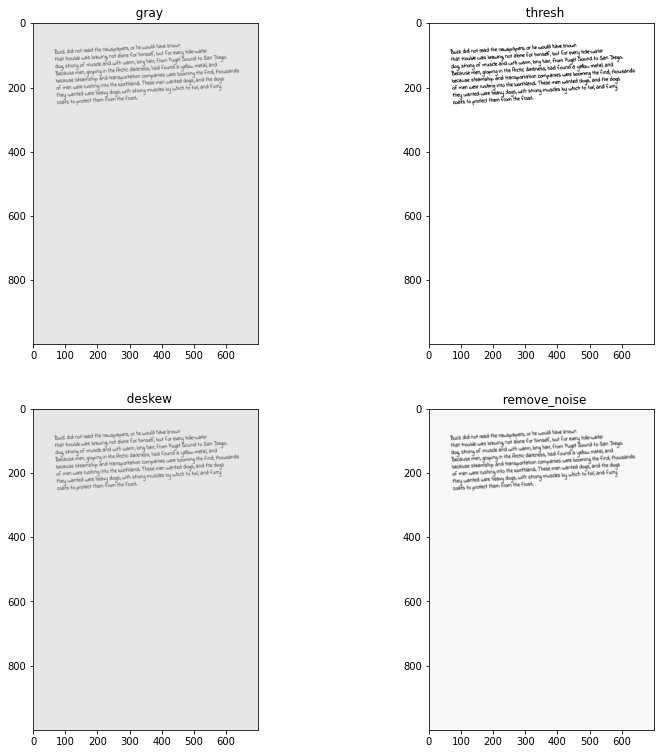

In [81]:
# Plot images after preprocessing

fig = plt.figure(figsize=(13,13))
ax = []

rows = 2
columns = 2
keys = list(images.keys())
for i in range(rows*columns):
    ax.append( fig.add_subplot(rows, columns, i+1) )
    ax[-1].set_title('  ' + keys[i]) 
    plt.imshow(images[keys[i]], cmap='gray')

In [82]:
print('TESSERACT OUTPUT --> ORIGINAL IMAGE')
print('-----------------------------------------')
print(pytesseract.image_to_string(image))
print('TESSERACT OUTPUT --> Grayscale')
print('-----------------------------------------')
print(pytesseract.image_to_string(gray))
print('TESSERACT OUTPUT --> THRESHOLDING')
print('-----------------------------------------')
print(pytesseract.image_to_string(thresh))
print('TESSERACT OUTPUT --> DESKEWING')
print('-----------------------------------------')
print(pytesseract.image_to_string(derotate))
print('TESSERACT OUTPUT --> NOISE REMOVAL')
print('-----------------------------------------')
print(pytesseract.image_to_string(denoise))

TESSERACT OUTPUT --> ORIGINAL IMAGE
-----------------------------------------
Buck did not read the newspapers oF he would have known

that trouble was brewing not alone For himselt, but For tidewater

dog, strong of muscle and with warm, long hair, from Puget nd to San Diego.
‘Because men, groping in the Arctic darkness, had found 3 yelow metal, and

because steamship: and transportation companies were ‘eooming the find, thousands
of men were rushing into the Northland. These men wanted dogs, and the dogs

i wanted were = dogs, uith strong rousdes by wich to tot, and fury

coats to. protect them From the Frost.

TESSERACT OUTPUT --> Grayscale
-----------------------------------------
Buck did not read the newspapers oF he would have known

that trouble was brewing not alone For himselt, but For tidewater

dog, strong of muscle and with warm, long hair, from Puget nd to San Diego.
‘Because men, groping in the Arctic darkness, had found 3 yelow metal, and

because steamship: and transp

## However, when we use an image that has an uneven shadow across it, the performance is much worse, and the thresholding becomes much more difficult to apply in a useful way.

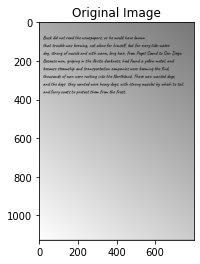

In [45]:
# Plot original image

image = cv2.imread('/content/drive/MyDrive/Lambda/Labs/Img_Outs/Buck_caveat_raw.jpeg')
b,g,r = cv2.split(image)
rgb_img = cv2.merge([r,g,b])
plt.imshow(rgb_img)
plt.title('Original Image')
plt.show()

In [64]:
# Preprocess image 

gray = get_grayscale(image)
thresh = thresholding(gray)
derotate = deskew(gray)
remove_noise = remove_noise(gray)
images = {'gray': gray, 
          'thresh': thresh, 
          'deskew': derotate, 
          'remove noise': denoise}

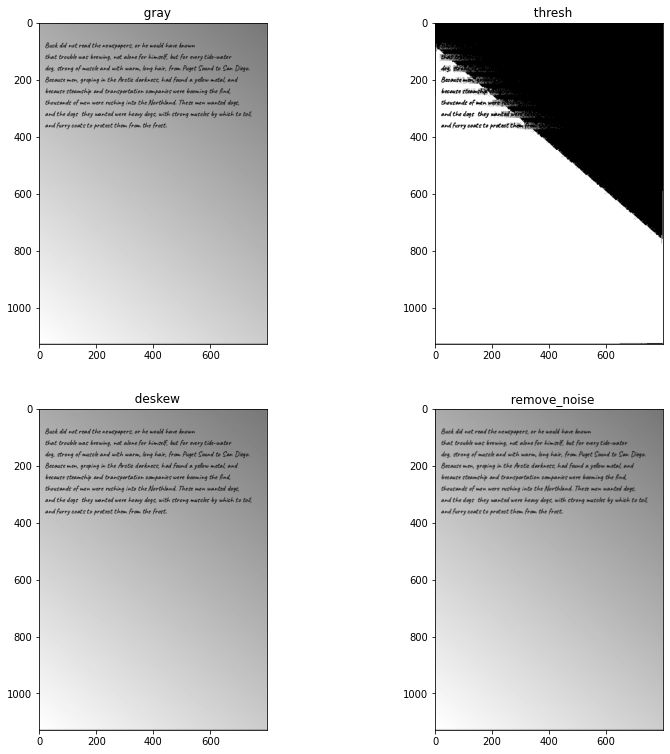

In [50]:
# Plot images after preprocessing

fig = plt.figure(figsize=(13,13))
ax = []

rows = 2
columns = 2
keys = list(images.keys())
for i in range(rows*columns):
    ax.append( fig.add_subplot(rows, columns, i+1) )
    ax[-1].set_title('  ' + keys[i]) 
    plt.imshow(images[keys[i]], cmap='gray')

In [49]:
print('TESSERACT OUTPUT --> ORIGINAL IMAGE')
print('-----------------------------------------')
print(pytesseract.image_to_string(image))
print('TESSERACT OUTPUT --> Grayscale')
print('-----------------------------------------')
print(pytesseract.image_to_string(gray))
print('TESSERACT OUTPUT --> THRESHOLDING')
print('-----------------------------------------')
print(pytesseract.image_to_string(thresh))
print('TESSERACT OUTPUT --> DESKEWING')
print('-----------------------------------------')
print(pytesseract.image_to_string(derotate))
print('TESSERACT OUTPUT --> NOISE REMOVAL')
print('-----------------------------------------')
print(pytesseract.image_to_string(remove_noise))

TESSERACT OUTPUT --> ORIGINAL IMAGE
-----------------------------------------
and furry coats to protect

 

 

TESSERACT OUTPUT --> Grayscale
-----------------------------------------
and furry coats to protect

 

 

TESSERACT OUTPUT --> THRESHOLDING
-----------------------------------------
and furry coats to protect

 

 

TESSERACT OUTPUT --> DESKEWING
-----------------------------------------
and furry coats to protect

 

 

TESSERACT OUTPUT --> NOISE REMOVAL
-----------------------------------------
 



### The whole process becomes much more difficult once we use real handwriting instead of fonts:

In [80]:
# When we try applying Tessaract directly on a real handwriting sample, bad lighting and all
# the result is pretty bad. (It says "By jove, my quick study of lexicography won a prize!")
pytesseract.image_to_string('/content/drive/MyDrive/Lambda/Labs/real_handwriting/by_jove_victor.jpg')

' \n\npec\n\n \n\nme\n\n, dl\n\n9\n\n~\n\n5 ast\n\nwee\nLe\n\nwt\n\n \n\n \n\x0c'

In [81]:
# This is "The quick brown fox jumps over a lazy dog."
pytesseract.image_to_string('/content/drive/MyDrive/Lambda/Labs/real_handwriting/qbf_max.png')

'The quel brown Loy Sune? over & \\az dog.\n\x0c'

In [82]:
# Again "The quick brown fox jumps over a lazy dog." from a different writer.
pytesseract.image_to_string('/content/drive/MyDrive/Lambda/Labs/real_handwriting/qbf_lew.png')

"The Avie lordun Lox james Over a lazy lag '\n\x0c"

In [110]:
# This is a young child's handwriting. Pretty much illegible by Tesseract.
pytesseract.image_to_string('/content/drive/MyDrive/Lambda/Labs/real_handwriting/kailyn.jpg')

'$8 be a Good space —\n\n \n\nQOAAe my Cechuity Sou\nhave +0. b€ plave, hec Pro!\n| Nae Kinds\n_feason You Lave Fo -\neis pecvnuse You _\n| at) oon tt WAL +o bt\n| _LOo€&Ly Ang Saal a\n| Tou have +o ns hepevl —\nale Bus hoe AN OFTHE? 4 $+Gnm |\n- And eee YouVe Jot to_\nbe Ki ad_ +90 mA e O XLLPA\nfrikad ia SPACK So hey\nYou and 4h? orien will\na be ry % aioe\n\n—\n\n \n\n \n\n \n\x0c'

Clearly, applying Tesseract directly to realy handwriting samples gives a pretty bad result.

We will not be able to use Tesseract "out of the box" for this purpose. In order to train a new neural network model, we can use one that is trained on the EMNIST dataset, which is a set of 145,600 images of letters, and their labels. Each image is 28x28 pixels, and each pixel is a grayscale value between 0 and 255.

In order to use a model that is trained on this dataset and "predict" or transcribe a new mage, we will need to feed each individual successive letter to the model.

Try applying bounding boxes to these letters. 

In [21]:
# Plot character boxes on image using pytesseract.image_to_boxes() function

image = cv2.imread('/content/drive/MyDrive/Lambda/Labs/real_handwriting/qbf_lew.png')

In [22]:
h, w, c = image.shape

In [23]:
h, w, c

(2700, 2087, 3)

In [24]:
boxes = pytesseract.image_to_boxes(image)

In [26]:
boxes.splitlines()

['T 132 2572 155 2631 0',
 'h 155 2572 188 2631 0',
 'e 206 2573 223 2605 0',
 'A 272 2540 301 2604 0',
 'v 313 2569 326 2609 0',
 'i 335 2569 340 2586 0',
 'e 350 2562 398 2605 0',
 'l 432 2554 444 2609 0',
 'o 444 2554 465 2609 0',
 'r 474 2565 486 2591 0',
 'd 486 2565 493 2591 0',
 'u 507 2564 528 2594 0',
 'n 528 2564 562 2594 0',
 'L 600 2566 622 2628 0',
 'o 622 2566 635 2628 0',
 'x 646 2565 668 2587 0',
 'j 704 2546 727 2591 0',
 'a 737 2563 758 2585 0',
 'm 769 2569 786 2586 0',
 'e 804 2555 814 2591 0',
 's 815 2566 840 2594 0',
 'O 872 2559 898 2597 0',
 'v 902 2568 918 2590 0',
 'e 932 2566 941 2594 0',
 'r 947 2567 966 2593 0',
 'a 986 2566 1014 2591 0',
 'l 1051 2571 1058 2616 0',
 'a 1066 2575 1084 2598 0',
 'z 1096 2569 1115 2594 0',
 'y 1131 2542 1161 2593 0',
 'l 1206 2572 1237 2619 0',
 'a 1244 2552 1256 2604 0',
 'g 1256 2552 1280 2604 0',
 "' 1305 2585 1312 2598 0"]

In [ ]:

 
for b in boxes.splitlines():
    b = b.split(' ')
    image = cv2.rectangle(image, (int(b[1]), h - int(b[2])), (int(b[3]), h - int(b[4])), (0, 255, 0), 2)

b,g,r = cv2.split(image)
rgb_img = cv2.merge([r,g,b])

plt.figure(figsize=(16,12))
plt.imshow(rgb_img)
plt.title('SAMPLE INVOICE WITH CHARACTER LEVEL BOXES')
plt.show()

The above draws the bounding boxes on the image, but we want to be able to create a new image from this box. (This should be able to be done by outputting a file from within each iteration in the for loop.)

Once this is done and we have files with one character per file, all in sequence for an entire message, we can use the following method: 
The EMNIST dataset will be imported, and a simple neural network model trained to it. This is a very bare-bones model to start, which can be worked with as desired, and then used to make a prediction, or transcription of the desired message.

This following process is adapted from this tutorial:
https://colab.research.google.com/drive/1NyYH1EPpaJlMBLK0fcKYz4icaD1SNSLK
 which accompanies this video lesson: https://youtu.be/6nGCGYWMObE

In [ ]:
# import the EMNIST library

!git clone https://github.com/sorki/python-mnist
!./python-mnist/bin/mnist_get_data.sh
!pip3 install emnist
from emnist import extract_training_samples

In [2]:
# Grab the data from the OpenML website
# X will be our images and y will be the labels
X, y = extract_training_samples('letters')

# Make sure that every pixel in all of the images is a value between 0 and 1
X = X / 255.

# Use the first 60000 instances as training and the next 10000 as testing
X_train, X_test = X[:60000], X[60000:70000]
y_train, y_test = y[:60000], y[60000:70000]

# There is one other thing we need to do, we need to
# record the number of samples in each dataset and the number of pixels in each image
X_train = X_train.reshape(60000,784)
X_test = X_test.reshape(10000,784)

Image Label: g


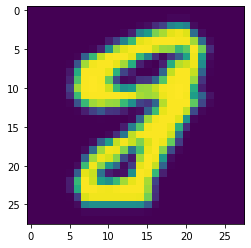

In [7]:
# Look at some of the images and labels in this dataset

import matplotlib.pyplot as plt

img_index = 3283 # <--- update this value to look at other images
img = X_train[img_index]
print("Image Label: " + str(chr(y_train[img_index]+96)))
plt.imshow(img.reshape((28,28)))

In [8]:
from sklearn.datasets import fetch_openml
from sklearn.neural_network import MLPClassifier

# This creates our first MLP with 1 hidden layer with 50 neurons and sets it to run through the data 20 times
mlp1 = MLPClassifier(hidden_layer_sizes=(50,), max_iter=20, alpha=1e-4,
                    solver='sgd', verbose=10, tol=1e-4, random_state=1,
                    learning_rate_init=.1)

In [9]:
mlp1.fit(X_train, y_train)
print("Training set score: %f" % mlp1.score(X_train, y_train))
print("Test set score: %f" % mlp1.score(X_test, y_test))

Iteration 1, loss = 1.06351395
Iteration 2, loss = 0.64844650
Iteration 3, loss = 0.56103245
Iteration 4, loss = 0.51987725
Iteration 5, loss = 0.49182099
Iteration 6, loss = 0.47301057
Iteration 7, loss = 0.45839220
Iteration 8, loss = 0.44603836
Iteration 9, loss = 0.43479721
Iteration 10, loss = 0.42809575
Iteration 11, loss = 0.41639233
Iteration 12, loss = 0.40782908
Iteration 13, loss = 0.40548360
Iteration 14, loss = 0.39965983
Iteration 15, loss = 0.39296832
Iteration 16, loss = 0.38883219
Iteration 17, loss = 0.38393955
Iteration 18, loss = 0.37948343
Iteration 19, loss = 0.37307616
Iteration 20, loss = 0.37166732


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Training set score: 0.886500
Test set score: 0.840800


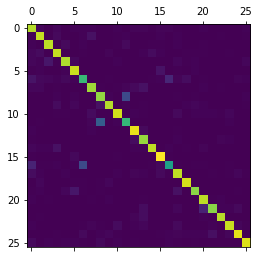

In [11]:
# Make predictions
y_pred = mlp1.predict(X_test)

# Visualize the errors between the predictions and the actual labels using a confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
plt.matshow(cm)

The rest of the process can be found in this tutorial:
https://colab.research.google.com/drive/1NyYH1EPpaJlMBLK0fcKYz4icaD1SNSLK
 which accompanies this video lesson: https://youtu.be/6nGCGYWMObE